# Genetic Algorithm for feature selection

A XGBoosting regression model will be build for modeling the pricing. Therefore, the feature selection process uses an instance of XGboost regressor to go through different rounds in the GA algorithm and get the most predictive variables. 





## Libraries

In [ ]:
%reload_ext autoreload
%autoreload 2

# visualisation and data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', 200)


# system and files managment
import os
import sys
import pickle
import ast
import collections

# model splits
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

# model
import xgboost as xg

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# modules added to system path
path_tools = os.path.abspath(r'/tools')
sys.path.extend([path_tools])

In [ ]:
sys.path

['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/tools',
 '/tools']

In [ ]:
import tools.feature_selection as fselec
import tools.exploring_tools as mtools

## Support functions

In [ ]:
def best_in_gene(best_scores):
    plt.plot(best_scores)
    plt.xlabel("Iterations")
    plt.ylabel("Fitness metrix")


def bests_chromos_coparison(bests_chromos, best_scores):
    """
    Comparing the best chromosomes to look for degenerated clases.

    :param bests_chromos: list with the chromosomes as numpy arrays
    :param best_scores: list with the score of each chromosome

    :return: list of tuples with the comparison and score:
    (index, pair of index compared, result of comparison,
    score of chromosome in the index)
    """
    list_compare = []
    for chromosome_idx in range(len(bests_chromos)):
        next_idx = (1 + chromosome_idx)%len(bests_chromos)
        list_compare.append((chromosome_idx,
                             "c{}-{}".format(chromosome_idx, next_idx),
                            (bests_chromos[chromosome_idx] == bests_chromos[next_idx]). all(),
                            "sc-{}".format(chromosome_idx), best_scores[chromosome_idx],
                             "# features {}".format(np.sum(bests_chromos[chromosome_idx]))))
    return list_compare

In [ ]:
def RMSE(y_true, y_pred):
    return np.sqrt(MSE(y_true, y_pred))

## Loading data set and list of variables

In [ ]:
df = pd.read_pickle('extended_data_set_pred_01_GA_pca.pick')

In [ ]:
var_set_1 = ['host_response_rate',
'host_acceptance_rate',
'host_is_superhost',
'latitude',
'longitude',
'accommodates',
'bedrooms',
'beds',
'has_availability',
'availability_30',
'availability_60',
'availability_90',
'availability_365',
'number_of_reviews',
'number_of_reviews_ltm',
'instant_bookable',
'reviews_per_month',
'room_type_num',
'months_since_first_reviews',
'months_with_reviews',
'months_as_host',
'predicted_price_log_01_GA',
'desccription_pca_x',
'desccription_pca_y',
'neighborhood_overview_pca_x',
'neighborhood_overview_pca_y',
'host_number_verifications',
'host_response_time_category']

var_to_predict = ['overall_review_value']

variables_have_to_be_in_model = ['predicted_price_log_01_GA',
'desccription_pca_x',
'desccription_pca_y',
'neighborhood_overview_pca_x',
'neighborhood_overview_pca_y']

In [ ]:
df[var_set_1 + var_to_predict].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52534 entries, 0 to 77132
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_response_rate           26940 non-null  float64
 1   host_acceptance_rate         34783 non-null  float64
 2   host_is_superhost            52505 non-null  float64
 3   latitude                     52534 non-null  float64
 4   longitude                    52534 non-null  float64
 5   accommodates                 52534 non-null  int64  
 6   bedrooms                     49500 non-null  float64
 7   beds                         52265 non-null  float64
 8   has_availability             52534 non-null  float64
 9   availability_30              52534 non-null  int64  
 10  availability_60              52534 non-null  int64  
 11  availability_90              52534 non-null  int64  
 12  availability_365             52534 non-null  int64  
 13  number_of_review

In [ ]:
df[var_set_1].describe()


,host_response_rate,host_acceptance_rate,host_is_superhost,latitude,longitude,accommodates,bedrooms,beds,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,instant_bookable,reviews_per_month,room_type_num,months_since_first_reviews,months_with_reviews,months_as_host,predicted_price_log_01_GA,desccription_pca_x,desccription_pca_y,neighborhood_overview_pca_x,neighborhood_overview_pca_y,host_number_verifications,host_response_time_category
count,26940.000000,34783.000000,52505.000000,52534.000000,52534.000000,52534.000000,49500.000000,52265.000000,52534.000000,52534.000000,52534.000000,52534.000000,52534.000000,52534.000000,52534.000000,52534.000000,52534.000000,52534.000000,52434.000000,52533.000000,52505.000000,52534.000000,52534.000000,52534.000000,52534.000000,52534.000000,52534.000000,26940.000000
mean,88.786377,83.267458,0.191410,51.509708,-0.128249,3.099916,1.465556,1.699053,0.998154,10.497030,23.118971,36.409525,118.105989,22.313549,2.308353,0.334755,0.627945,1.446073,27.403288,17.399806,61.538234,4.341194,-0.010060,-0.003045,0.029624,-0.006458,72.122911,1.784855
std,25.029496,26.748903,0.393415,0.046805,0.093315,1.875519,0.807026,1.210219,0.042931,12.847746,26.280841,39.843438,141.496877,41.069912,5.393178,0.471909,0.876182,0.552891,25.097938,20.245726,27.401397,0.607505,0.178882,0.170314,0.188837,0.142652,30.667172,0.981189
min,0.000000,0.000000,0.000000,51.297330,-0.494850,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.010000,1.000000,0.000000,0.000000,0.000000,2.697338,-0.499787,-0.557844,-0.203779,-0.484467,2.000000,1.000000
25%,91.000000,78.000000,0.000000,51.483925,-0.188230,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.120000,1.000000,4.000000,2.000000,42.000000,3.816238,-0.145618,-0.118636,-0.203779,-0.101405,55.000000,1.000000
50%,100.000000,97.000000,0.000000,51.514020,-0.124450,2.000000,1.000000,1.000000,1.000000,0.000000,1.000000,7.000000,47.000000,8.000000,1.000000,0.000000,0.340000,1.000000,22.000000,10.000000,63.000000,4.365006,-0.020968,-0.005863,0.059559,0.033219,79.000000,1.000000
75%,100.000000,100.000000,0.000000,51.538717,-0.069930,4.000000,2.000000,2.000000,1.000000,27.000000,56.000000,86.000000,242.000000,24.000000,3.000000,1.000000,0.800000,2.000000,44.000000,27.000000,81.000000,4.796490,0.123068,0.109383,0.184658,0.033219,96.000000,3.000000
max,100.000000,100.000000,1.000000,51.679980,0.288570,16.000000,12.000000,21.000000,1.000000,30.000000,60.000000,90.000000,365.000000,817.000000,479.000000,1.000000,36.830000,4.000000,141.000000,123.000000,148.000000,6.383001,0.563138,0.564358,0.525866,0.625052,180.000000,4.000000


In [ ]:
df['overall_review_value'].isnull().any()

False

In [ ]:
df['overall_review_value_log'] = np.log(df['overall_review_value'])

## Dividig data into Train/Test

In [ ]:
y = df['overall_review_value'].values

In [ ]:
y

array([88.1, 91.7, 91.6, ..., 95. , 95. , 95. ])

In [ ]:
X = df[var_set_1].copy()

In [ ]:
X.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,latitude,longitude,accommodates,bedrooms,beds,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,instant_bookable,reviews_per_month,room_type_num,months_since_first_reviews,months_with_reviews,months_as_host,predicted_price_log_01_GA,desccription_pca_x,desccription_pca_y,neighborhood_overview_pca_x,neighborhood_overview_pca_y,host_number_verifications,host_response_time_category
0,100.0,90.0,0.0,51.46225,-0.11732,4,1.0,3.0,1.0,3,33,63,338,192,6,1.0,1.46,1,5.0,120.0,134.0,4.323723,-0.207060,-0.071857,0.115708,-0.066403,109,1.0
1,100.0,75.0,0.0,51.56802,-0.11121,2,1.0,0.0,1.0,30,60,90,365,21,1,0.0,0.17,2,9.0,114.0,133.0,3.916180,-0.156919,-0.140670,0.126038,-0.127408,93,2.0
2,NaN,100.0,0.0,51.48796,-0.16898,2,1.0,1.0,1.0,29,59,62,189,89,1,1.0,0.66,1,0.0,123.0,132.0,4.845178,-0.078360,-0.289400,-0.203779,0.033219,55,NaN
3,0.0,100.0,1.0,51.52195,-0.14094,6,3.0,3.0,1.0,16,16,16,231,42,0,0.0,0.35,1,14.0,104.0,131.0,5.372856,-0.065268,-0.359259,0.042830,-0.185334,123,4.0
5,NaN,100.0,1.0,51.57224,-0.20906,2,1.0,0.0,1.0,0,0,0,2,129,3,1.0,0.99,2,0.0,119.0,128.0,3.541085,0.140470,0.309092,-0.061274,-0.136107,100,NaN


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)

In [ ]:
X_train.shape

(42027, 28)

In [ ]:
X_train.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,latitude,longitude,accommodates,bedrooms,beds,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,instant_bookable,reviews_per_month,room_type_num,months_since_first_reviews,months_with_reviews,months_as_host,predicted_price_log_01_GA,desccription_pca_x,desccription_pca_y,neighborhood_overview_pca_x,neighborhood_overview_pca_y,host_number_verifications,host_response_time_category
15530,100.0,100.0,0.0,51.55328,-0.03971,2,1.0,1.0,1.0,2,2,2,2,1,0,0.0,0.02,1,47.0,0.0,101.0,4.348993,-0.089491,-0.080442,0.158780,-0.088950,109,1.0
70846,100.0,86.0,0.0,51.54068,-0.24709,5,3.0,3.0,1.0,9,39,69,344,7,7,0.0,1.44,1,89.0,4.0,93.0,4.699843,-0.277439,-0.075757,0.134292,0.000881,119,1.0
57527,0.0,100.0,0.0,51.53604,-0.08293,7,2.0,2.0,1.0,0,0,18,293,3,1,1.0,0.22,1,3.0,3.0,16.0,5.110343,0.133899,-0.035595,0.074392,-0.152544,18,4.0
47798,NaN,100.0,0.0,51.52894,-0.07255,2,1.0,1.0,1.0,0,0,0,0,33,0,0.0,1.48,2,46.0,5.0,68.0,3.706230,-0.092096,0.183666,-0.030976,-0.088913,29,NaN
926,100.0,95.0,1.0,51.42715,-0.14573,2,1.0,1.0,1.0,27,57,87,177,248,14,0.0,2.50,2,4.0,98.0,102.0,3.682660,0.067295,0.216690,-0.203779,0.033219,81,3.0


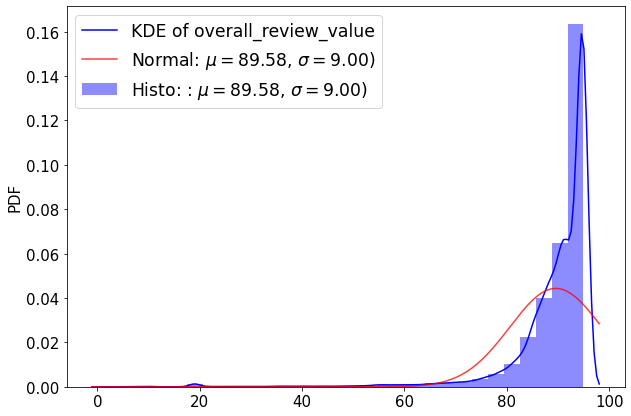

In [ ]:
mtools.plotting_one_dist_norm_kde(df, 'overall_review_value')
None

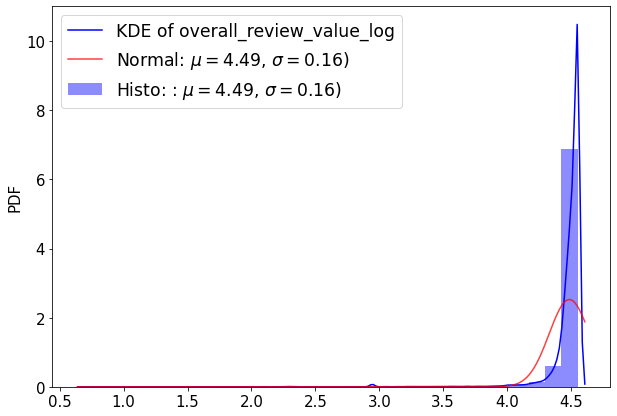

In [ ]:
mtools.plotting_one_dist_norm_kde(df, 'overall_review_value_log')
None

# Genetic Algorithm feature selection rounds

## 1st Round

In [ ]:
# Instantiation 
clf = xg.XGBRegressor(objective ='reg:squarederror', 
                        max_depth=3, 
                        n_estimators=100, 
                        random_state=0)

In [ ]:
# set importance type to gain rather than default 'split'
clf.set_params(importance_type='gain')

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
clf.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
pred_test = clf.predict(X_test)

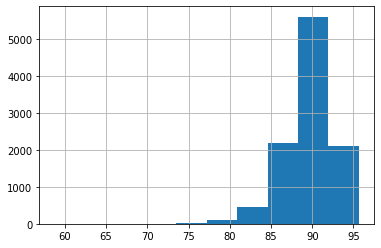

In [ ]:
pd.Series(pred_test).hist()

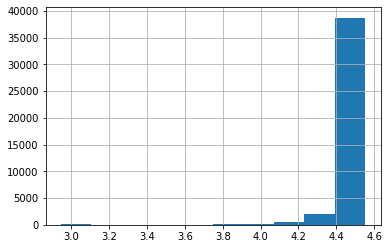

In [ ]:
pd.Series(y_train).hist()

In [ ]:
MSE(y_test, pred_test)

73.96078839524273

In [ ]:
# Instantiation 
clf = xg.XGBRegressor(objective ='reg:squarederror', 
                        max_depth=3, 
                        n_estimators=100, 
                        random_state=0)

In [ ]:
bests_chromos_hlf_4, best_scores_hlf_4 = fselec.generations_v4(size=200,
                                                              n_feat=X_train.shape[1],
                                                              metric=RMSE,
                                                              clf=clf,
                                                              n_parents=100,
                                                              mutation_rate=0.2, 
                                                              n_generations=10,
                                                              X_train=X_train,
                                                              y_train=y_train,
                                                              percent_not_feat=0.7,
                                                              seed=42,
                                                              random_state_fit=42,
                                                              classification=False,
                                                              early_stop_ths=0.005,
                                                              early_stop_falg=False)

[8.426539735204322, 8.4360142438292]
[8.379548928454385, 8.381501156377208]
[8.349398242114884, 8.356613816012201]
[8.349398242114884, 8.354366518689245]
[8.349398242114884, 8.350974357399734]
[8.334504573615105, 8.349398242114884]
[8.334504573615105, 8.349083310552102]
[8.334504573615105, 8.349083310552102]
[8.334504573615105, 8.349083310552102]
[8.334504573615105, 8.340062075055114]


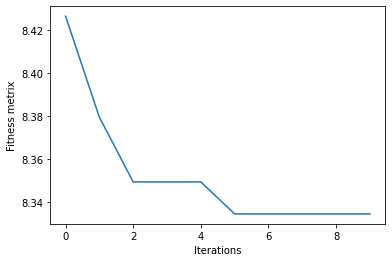

In [ ]:
best_in_gene(best_scores_hlf_4)

In [ ]:
list_compare_hlf_4 = bests_chromos_coparison(bests_chromos=bests_chromos_hlf_4, 
                                             best_scores=best_scores_hlf_4)

In [ ]:
list_compare_hlf_4

[(0, 'c0-1', False, 'sc-0', 8.426539735204322, '# features 9'),
 (1, 'c1-2', False, 'sc-1', 8.379548928454385, '# features 16'),
 (2, 'c2-3', True, 'sc-2', 8.349398242114884, '# features 15'),
 (3, 'c3-4', True, 'sc-3', 8.349398242114884, '# features 15'),
 (4, 'c4-5', False, 'sc-4', 8.349398242114884, '# features 15'),
 (5, 'c5-6', True, 'sc-5', 8.334504573615105, '# features 21'),
 (6, 'c6-7', True, 'sc-6', 8.334504573615105, '# features 21'),
 (7, 'c7-8', True, 'sc-7', 8.334504573615105, '# features 21'),
 (8, 'c8-9', True, 'sc-8', 8.334504573615105, '# features 21'),
 (9, 'c9-0', False, 'sc-9', 8.334504573615105, '# features 21')]

In [ ]:
print(bests_chromos_hlf_4[-1])
X_train.iloc[:,bests_chromos_hlf_4[-1]].columns

[ True  True  True  True False  True  True False  True False  True  True
 False  True  True  True  True False  True  True  True  True False False
  True  True  True  True]


Index(['host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'latitude', 'accommodates', 'bedrooms', 'has_availability',
       'availability_60', 'availability_90', 'number_of_reviews',
       'number_of_reviews_ltm', 'instant_bookable', 'reviews_per_month',
       'months_since_first_reviews', 'months_with_reviews', 'months_as_host',
       'predicted_price_log_01_GA', 'neighborhood_overview_pca_x',
       'neighborhood_overview_pca_y', 'host_number_verifications',
       'host_response_time_category'],
      dtype='object')

In [ ]:
first_round_list = ['host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'latitude', 'accommodates', 'bedrooms', 'has_availability',
       'availability_60', 'availability_90', 'number_of_reviews',
       'number_of_reviews_ltm', 'instant_bookable', 'reviews_per_month',
       'months_since_first_reviews', 'months_with_reviews', 'months_as_host',
       'predicted_price_log_01_GA', 'neighborhood_overview_pca_x',
       'neighborhood_overview_pca_y', 'host_number_verifications',
       'host_response_time_category']

In [ ]:
len(first_round_list)

21

In [ ]:
X_train_01 = X_train[first_round_list].copy()

In [ ]:
clf_01 = xg.XGBRegressor(objective ='reg:squarederror', 
                        max_depth=3, 
                        n_estimators=100, 
                        random_state=0)

In [ ]:
clf_01.fit(X_train[first_round_list], y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

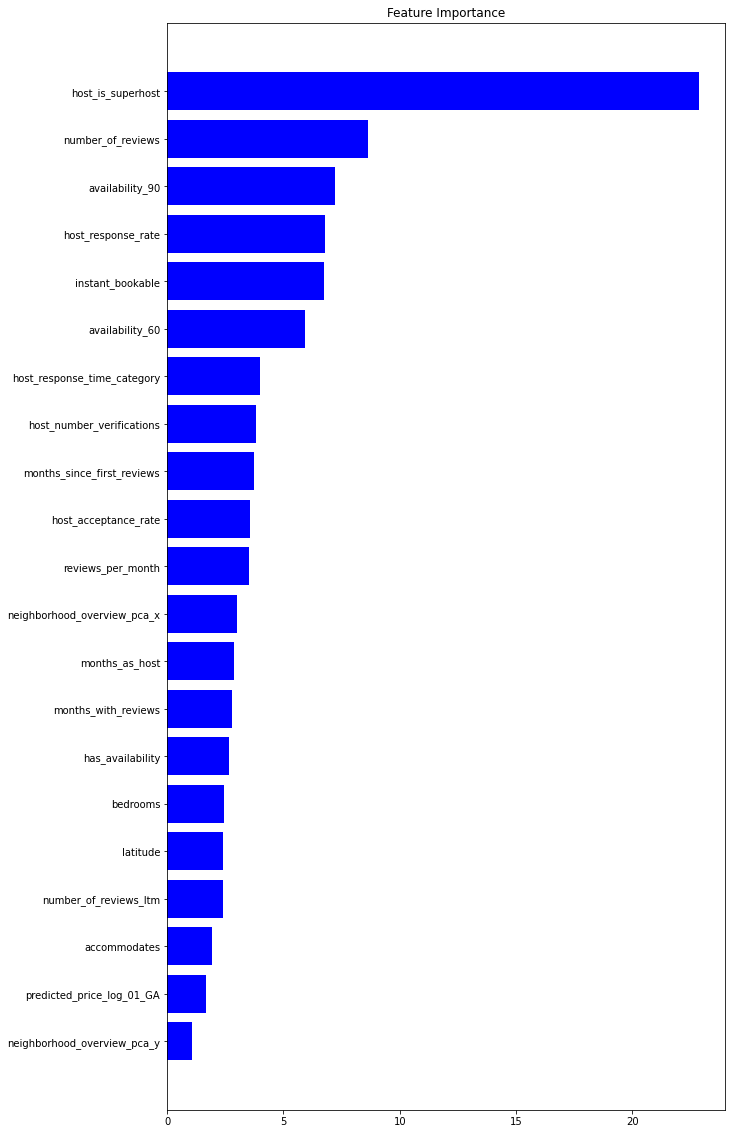

In [ ]:
df_feature_importance_01 = fselec.feature_importance(model=clf_01, 
                                                     model_type='Uncalibrated',
                                                     feature_list=first_round_list)                

In [ ]:
df_feature_importance_01

,Feature_importance%
host_is_superhost,22.849339
number_of_reviews,8.645720
availability_90,7.195233
host_response_rate,6.805638
instant_bookable,6.723384
availability_60,5.905622
host_response_time_category,3.982886
host_number_verifications,3.823455
months_since_first_reviews,3.727949
host_acceptance_rate,3.572392


In [ ]:
X_test_01 = X_test[first_round_list].copy()

In [ ]:
# Predict the model 
pred_1 = clf_01.predict(X_test_01) 
pred_1

array([88.95383 , 85.966934, 80.43777 , ..., 89.295364, 92.634605,
       91.46371 ], dtype=float32)

In [ ]:
# evaluating prediction
rmse_1 = RMSE(y_test, pred_1)
rmse_1

8.583403516021423

In [ ]:
corr_spear_1 = df[first_round_list + ['overall_review_value']].corr(method='spearman').abs()

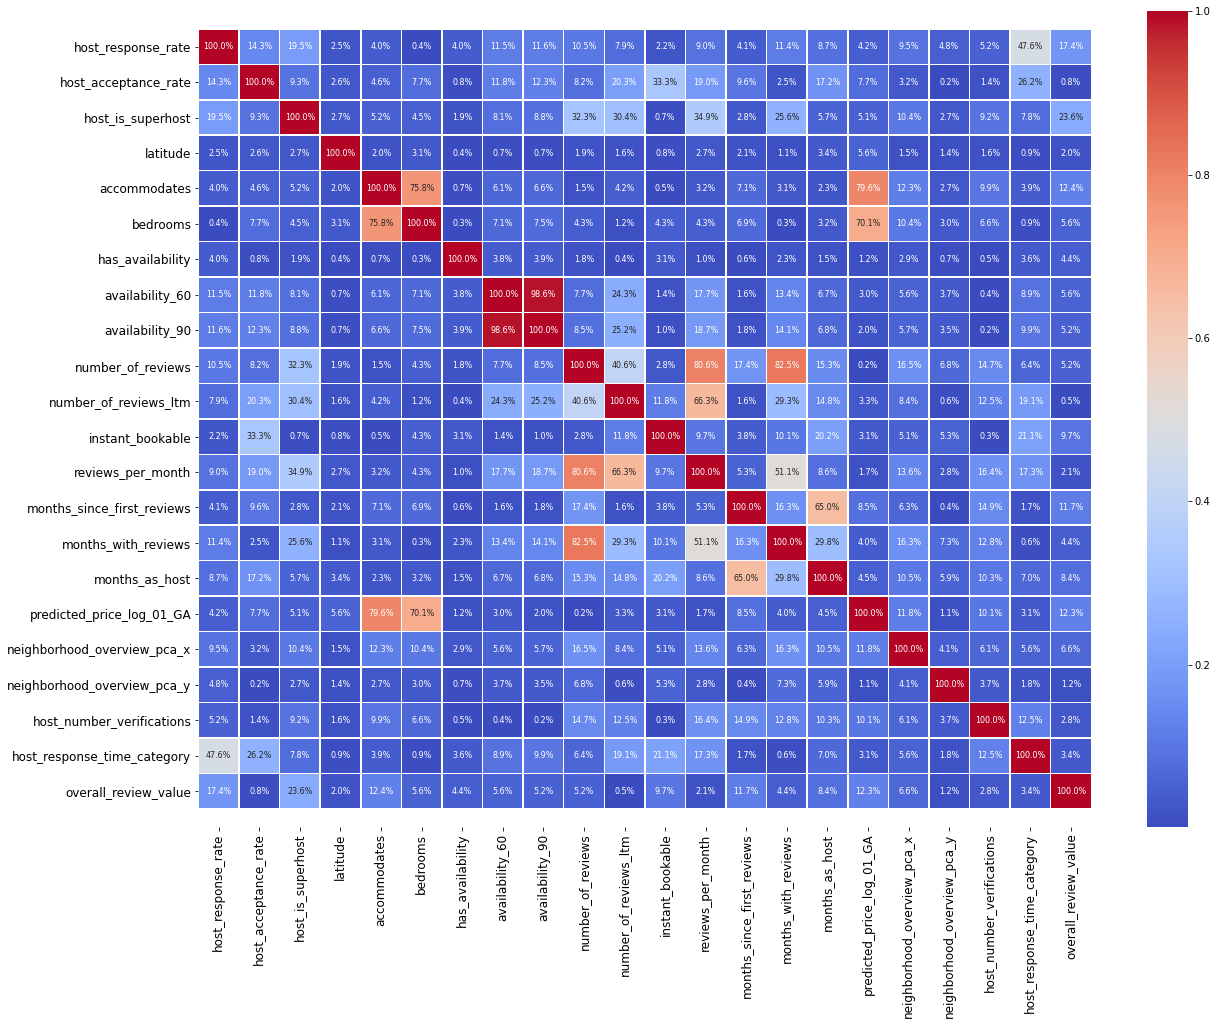

In [ ]:
mtools.heat_map_corr(corr_spear_1, cmap='coolwarm', square=False, annot=True)

In the firts round, three variables out of 5 required in the model survived (predicted  price from the first model, and the neighbourhood overview pca transformation). From the correlation matrix and the feature importance, it will be dropped some variables regarding reviews, host response, and accomodation.

* accommodates is dropped since bedrooms is more important.
* host_response_time_category is dropped since host_response_rate is more important.
* months_with_reviews, and number_of_reviews_ltm is dropped since reviews per month is more important. 

In [ ]:
list_var_to_keep = ['host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'latitude',
 'bedrooms',
 'has_availability',
 'availability_60',
 'availability_90',
 'number_of_reviews',
 'instant_bookable',
 'reviews_per_month',
 'months_since_first_reviews',
 'months_as_host',
 'predicted_price_log_01_GA',
 'neighborhood_overview_pca_x',
 'neighborhood_overview_pca_y',
 'desccription_pca_x',
 'desccription_pca_y',
 'host_number_verifications']

In [ ]:
corr_spear_2 = df[list_var_to_keep + ['overall_review_value']].corr(method='spearman').abs()

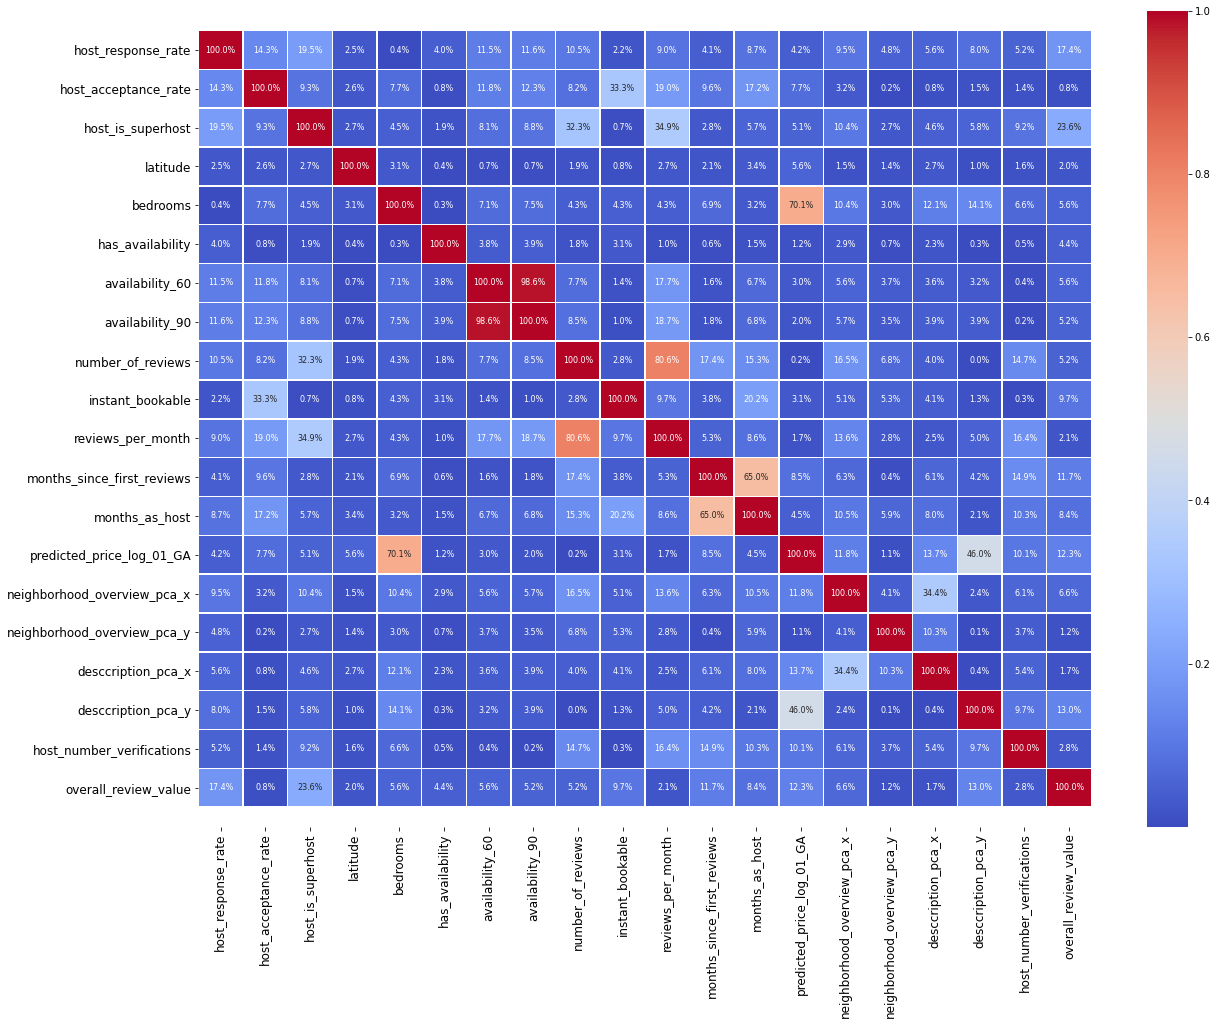

In [ ]:
mtools.heat_map_corr(corr_spear_2, cmap='coolwarm', square=False, annot=True)

In [ ]:
X_train_02 = X_train[list_var_to_keep].copy()

In [ ]:
clf_02 = xg.XGBRegressor(objective ='reg:squarederror', 
                        max_depth=3, 
                        n_estimators=100, 
                        random_state=0)

In [ ]:
clf_02.fit(X_train_02, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

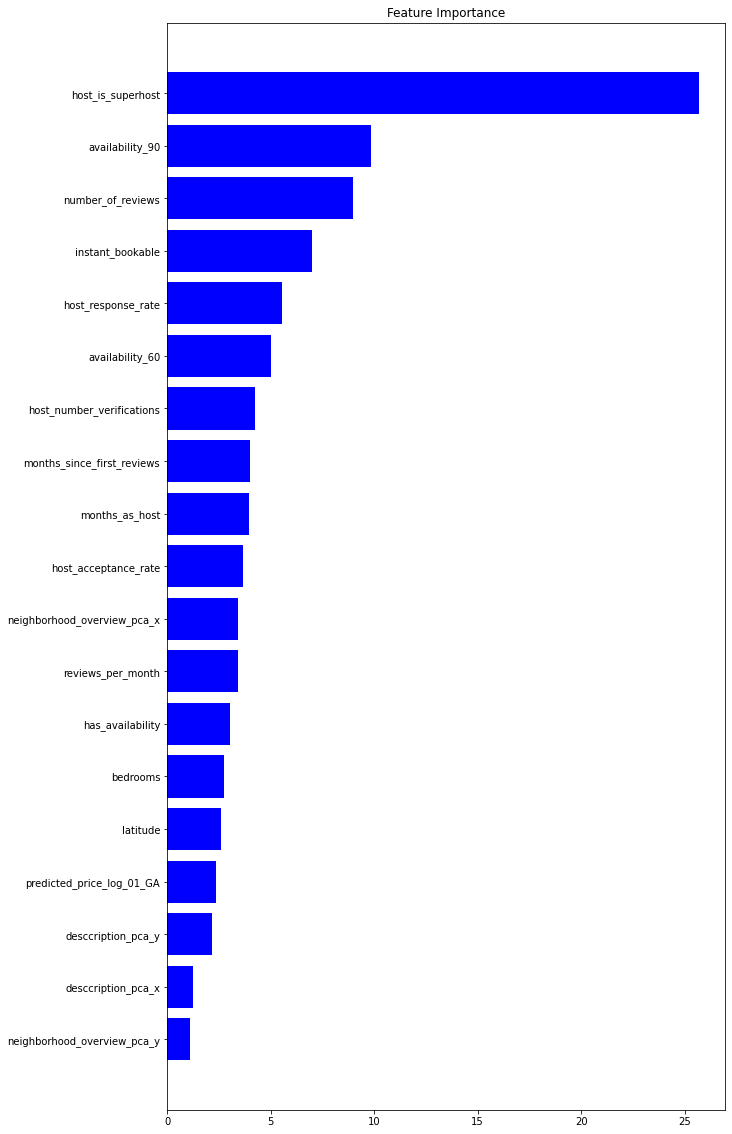

In [ ]:
df_feature_importance_02 = fselec.feature_importance(model=clf_02, 
                                                     model_type='Uncalibrated',
                                                     feature_list=list_var_to_keep)                

In [ ]:
df_feature_importance_02

,Feature_importance%
host_is_superhost,25.673542
availability_90,9.822762
number_of_reviews,8.996095
instant_bookable,6.982974
host_response_rate,5.553941
availability_60,4.991377
host_number_verifications,4.252883
months_since_first_reviews,4.019692
months_as_host,3.929407
host_acceptance_rate,3.661424


In [ ]:
X_test_02 = X_test[list_var_to_keep].copy()

In [ ]:
# Predict the model 
pred_2 = clf_02.predict(X_test_02) 
pred_2

array([88.84194 , 86.03727 , 79.403175, ..., 88.52758 , 92.32556 ,
       91.4475  ], dtype=float32)

In [ ]:
# evaluating prediction
rmse_2= RMSE(y_test, pred_2)
rmse_2

8.626152897993798

In [ ]:
len(list_var_to_keep)

19

The relative drop of RMSE is smaller while incorporating the two description_pca variables, and dropping some others with correlation. 

In [ ]:
# The performance droped 0.5% relative to the GA model. 
print("Change in performance", rmse_2 - rmse_1)
print("Change in %", ((rmse_2 - rmse_1) / rmse_1) * 100)

Change in performance 0.04274938197237432
Change in % 0.49804697976251616
